## 0. Constants/Imports

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys,os
import argparse
from tqdm import tqdm

#CAFPYANA working directory
CAFPYANA_WD = '/exp/sbnd/app/users/brindenc/develop/cafpyana'
os.environ['CAFPYANA_WD'] = CAFPYANA_WD

cafpyana_wd = os.environ.get('CAFPYANA_WD')
if cafpyana_wd and cafpyana_wd not in sys.path:
    sys.path.insert(0, cafpyana_wd)
    sys.path.insert(0, cafpyana_wd + '/pyanalib')

#My imports 
SBNDANA_DIR = '/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd'
WIENER_DIR = '/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/unfolding'
sys.path.insert(0,SBNDANA_DIR)
sys.path.insert(0,f'{SBNDANA_DIR.replace("/numuincl/sbnd","/numuincl")}')
sys.path.insert(0,WIENER_DIR)
plt.style.use(f'{SBNDANA_DIR}/plotlibrary/numu2025.mplstyle')

#My imports
from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.interaction import CAFInteraction
from sbnd.cafclasses.nu import NU
from sbnd.constants import *
from sbnd.numu.numu_constants import *
from sbnd.detector.definitions import * # >= v2.2
from sbnd.general import plotters

#Weiner imports
from wienersvd import *
from unfolding_inputs import *

%load_ext autoreload
%autoreload 2

In [422]:
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both'
PLOT_DIR = f'{DATA_DIR}/plots/{plotters.day}/unfolding'

MC_FNAME = 'small/mc_small_syst_postprocess_cut.df'
OFFBEAM_FNAME = 'data_offbeam.df'
DATA_FNAME = 'data_dev.df'
FLUX_FILE = '/exp/sbnd/data/users/munjung/flux/sbnd_original_flux.root'
APPLY_CUTS = False

from naming import * #Import naming labels, cut names, shit like dat

In [423]:
RHO = 1.3836  #g/cm3, liquid Ar density
N_A = 6.02214076e23 # Avogadro’s number
M_AR = 39.95 # g, molar mass of argon
V_SBND = 380 * 380 * 440 # cm3, the fiducial volume of the detector 
NTARGETS = np.float64(RHO * V_SBND * N_A / M_AR)
print("# of targets: ", NTARGETS)

# of targets:  1.3251484770937053e+30


## 1. Load data

In [424]:
# Get keys for h5 files
import h5py
mc_pand_keys = []
offbeam_pand_keys = []
data_pand_keys = []
mc_inter_keys = []
offbeam_inter_keys = []
data_inter_keys = []
mcnu_keys = []
hdr_keys = []
offbeam_hdr_keys = []
data_hdr_keys = []
# Check the keys in the H5 Files
for fname in [MC_FNAME,OFFBEAM_FNAME,DATA_FNAME]:
  print(f'File: {DATA_DIR}/{fname}')
  with h5py.File(f'{DATA_DIR}/{fname}', 'r') as f:
    # Store all keys at the root level
    for key in f.keys():
      if 'pand' in key:
        if fname == MC_FNAME:
          mc_pand_keys.append(key)
        elif fname == OFFBEAM_FNAME:
          offbeam_pand_keys.append(key)
        elif fname == DATA_FNAME:
          data_pand_keys.append(key)
      elif 'evt' in key and 'pand' not in key:
        if fname == MC_FNAME:
          mc_inter_keys.append(key)
        elif fname == OFFBEAM_FNAME:
          offbeam_inter_keys.append(key)
        elif fname == DATA_FNAME:
          data_inter_keys.append(key)
      elif 'mcnu' in key:
        if fname == MC_FNAME:
          mcnu_keys.append(key)
      elif 'hdr' in key:
        if fname == MC_FNAME:
          hdr_keys.append(key)
        elif fname == OFFBEAM_FNAME:
          offbeam_hdr_keys.append(key)
        elif fname == DATA_FNAME:
          data_hdr_keys.append(key)
print(mc_pand_keys,offbeam_pand_keys,mc_inter_keys,offbeam_inter_keys,mcnu_keys,hdr_keys)

File: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/small/mc_small_syst_postprocess_cut.df
File: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/data_offbeam.df
File: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/data_dev.df
['pandora', 'pandora_signal'] ['evt_pand_0'] [] ['evt_0'] ['mcnu'] []


In [ ]:
LIVETIME_DATA = 9.51e5 # From medulla
POT_MC = 0
for key in hdr_keys:
  POT_MC += pd.read_hdf(f'{DATA_DIR}/{MC_FNAME}',key=key).pot.sum()
LIVETIME_DATAOFFBEAM = 0
for key in offbeam_hdr_keys:
  LIVETIME_DATAOFFBEAM += pd.read_hdf(f'{DATA_DIR}/{OFFBEAM_FNAME}',key=key).noffbeambnb.sum()
POT_DATA = 0
#LIVETIME_DATA = 0
for key in data_hdr_keys:
  _hdr_df = pd.read_hdf(f'{DATA_DIR}/{DATA_FNAME}',key=key)
  POT_DATA += _hdr_df.pot.sum()
  #LIVETIME_DATA += _hdr_df.noffbeambnb.sum()

#Get POT label
pot_mag = int(np.floor(np.log10(POT_DATA)))
pot_base = POT_DATA/10**pot_mag
POT_LABEL = f'{pot_base:.2f} x 10$^{{{pot_mag}}}$ POT'
print(f'data POT: {POT_LABEL}, mc POT: {POT_MC:.2e}, offbeam livetime: {LIVETIME_DATAOFFBEAM:.2e}, data livetime: {LIVETIME_DATA:.2e}')

data POT: 4.58 x 10$^{18}$ POT, mc POT: 0.00e+00, offbeam livetime: 1.21e+06, data livetime: 9.51e+05


In [427]:
#MC_FNAME = 'mc_small.df'
slc = CAFSlice.load(f"{DATA_DIR}/{MC_FNAME}",key='pandora')
slc_signal = CAFSlice.load(f"{DATA_DIR}/{MC_FNAME}",key='pandora_signal')

inter = CAFInteraction.load(f"{DATA_DIR}/{MC_FNAME}",key='spine')
inter_signal = CAFInteraction.load(f"{DATA_DIR}/{MC_FNAME}",key='spine_signal')
mcnu = NU.load(f"{DATA_DIR}/{MC_FNAME}",key='mcnu')
#PLOT_DIR += '_small'

#slc_data = CAFSlice.load(f"{DATA_DIR}/{DATA_FNAME.replace('.df','_postprocess.df')}",key='pandora')
#inter_data = CAFInteraction.load(f"{DATA_DIR}/{DATA_FNAME.replace('.df','_postprocess.df')}",key='spine')

### 1.1 Rescale to MC POT (optional)

In [428]:
POT_MC

0

In [430]:
old_pot_data = POT_DATA
POT_DATA = 3.48e20 # Run 1 stats
POT_LABEL = '3.48 x 10$^{20}$ POT'

# Rescale to POT_DATA
slc.scale_to_pot(POT_DATA,sample_pot=old_pot_data)
inter.scale_to_pot(POT_DATA,sample_pot=old_pot_data)
mcnu.scale_to_pot(POT_DATA,sample_pot=old_pot_data)
slc_signal.scale_to_pot(POT_DATA,sample_pot=old_pot_data)
inter_signal.scale_to_pot(POT_DATA,sample_pot=old_pot_data)

--scaling to POT (7.60e+01): 4.58e+18 -> 3.48e+20
--scaling to POT (7.60e+01): 4.58e+18 -> 3.48e+20
--scaling to POT (7.60e+01): 4.58e+18 -> 3.48e+20
--scaling to POT (7.60e+01): 4.58e+18 -> 3.48e+20
--scaling to POT (7.60e+01): 4.58e+18 -> 3.48e+20


### 1.2 Extract selected signal

In [431]:
is_signal = np.isin(slc.data.truth.event_type,[0,1])
slc_selected_signal = CAFSlice(slc.data[is_signal])

is_signal = np.isin(inter.data.truth.event_type,[0,1])
inter_selected_signal = CAFInteraction(inter.data[is_signal])

### 1.3 Flux

In [432]:
# Extract flux from the flux file
flux = uproot.open(FLUX_FILE)

# numu flux
numu_flux = flux["flux_sbnd_numu"].to_numpy()
bin_edges = numu_flux[1]
flux_vals = numu_flux[0]

# get integrated flux
integrated_flux = flux_vals.sum()
integrated_flux /= 1e4 # to cm2
INTEGRATED_FLUX = np.float64(integrated_flux * POT_DATA / 1e6) # POT
print("Integrated flux: %.3e" % INTEGRATED_FLUX)

Integrated flux: 5.620e+12


In [433]:
XSEC_UNIT = 1/ (INTEGRATED_FLUX * NTARGETS)
print(f'Xsec unit: {XSEC_UNIT}')

Xsec unit: 1.342824144508688e-43


## 2. Distributions with different universes

In [434]:
#Costheta
stat_weights = slc.data.truth.stat.values
genweights = slc.data.genweight.values
reco_costheta = slc.data.mu.pfp.trk.costheta
true_costheta = slc.data.truth.mu.dir.z

stat_weights_sel = slc_selected_signal.data.truth.stat.values
genweights_sel = slc_selected_signal.data.genweight.values
true_sel_costheta = slc_selected_signal.data.truth.mu.dir.z
reco_sel_costheta = slc_selected_signal.data.mu.pfp.trk.costheta

stat_weights_sig = slc_signal.data.truth.stat.values
genweights_sig = slc_signal.data.genweight.values
true_sig_costheta = slc_signal.data.truth.mu.dir.z
reco_sig_costheta = slc_signal.data.mu.pfp.trk.costheta

#costheta_bins = np.array([-1,0,1])
costheta_bins = COSTHETA_BINS
costheta_centers = (costheta_bins[:-1] + costheta_bins[1:])/2.

label_y_shift = 0.

In [435]:
genweights_sig[0],genweights_sel[0]

(1686.6540089802704, 1686.6540089802704)

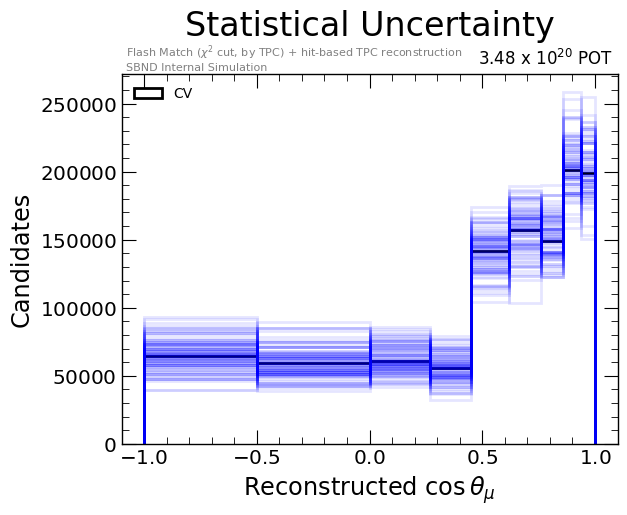

In [436]:
fig,ax = plt.subplots()
ax.hist(reco_costheta,bins=costheta_bins,weights=genweights,label='CV',histtype='step',color='black',alpha=1.)
for i,_weights in enumerate(stat_weights.T):
  ax.hist(reco_costheta,weights=_weights*genweights,bins=costheta_bins,histtype='step',color='blue',alpha=0.1)

ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel('Candidates')
ax.legend()
ax.set_title('Statistical Uncertainty')
plotters.add_label(ax,POT_LABEL,where='toprightoutside',color='black',alpha=1.,fontsize=12)
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
plotters.save_plot('reco_costheta_univs',fig=fig,folder_name=f'{PLOT_DIR}/stat/pandora')

## 3. Response matrix

### 3.1 Efficiency and signal vs selected

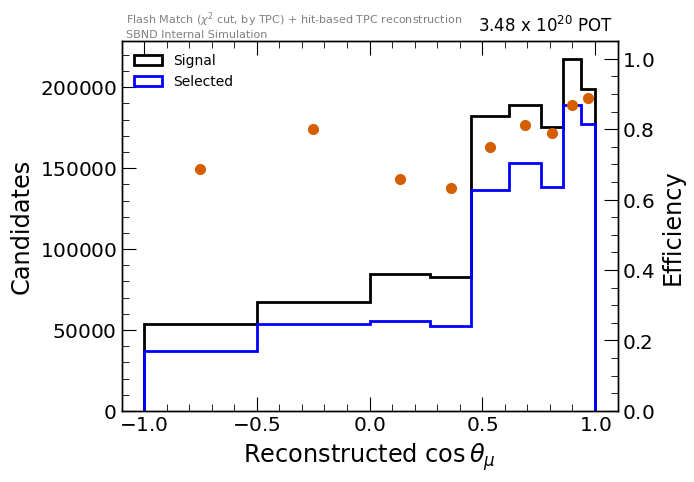

In [437]:
fig,ax = plt.subplots()
slc_costheta_sig,_,_ = ax.hist(reco_sig_costheta,bins=costheta_bins,weights=genweights_sig,label='Signal',histtype='step',color='black',alpha=1.)
slc_costheta_sel,_,_ = ax.hist(reco_sel_costheta,bins=costheta_bins,weights=genweights_sel,label='Selected',histtype='step',color='blue',alpha=1.)
slc_costheta_eff = slc_costheta_sel/slc_costheta_sig
assert np.nanmax(slc_costheta_eff) <= 1.0, f'Efficiency is greater than 100%: {np.nanmax(slc_costheta_eff)}'
ax2 = ax.twinx()
ax2.scatter(costheta_centers,slc_costheta_eff,label='Efficiency')
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel('Candidates')
ax2.set_ylim(0,1.05)
ax2.set_ylabel('Efficiency')

plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
plotters.add_label(ax,POT_LABEL,where='toprightoutside',color='black',alpha=1.,fontsize=12)
ax.legend()

plotters.save_plot('reco_costheta_sel_signal_eff',fig=fig,folder_name=f'{PLOT_DIR}/pandora')

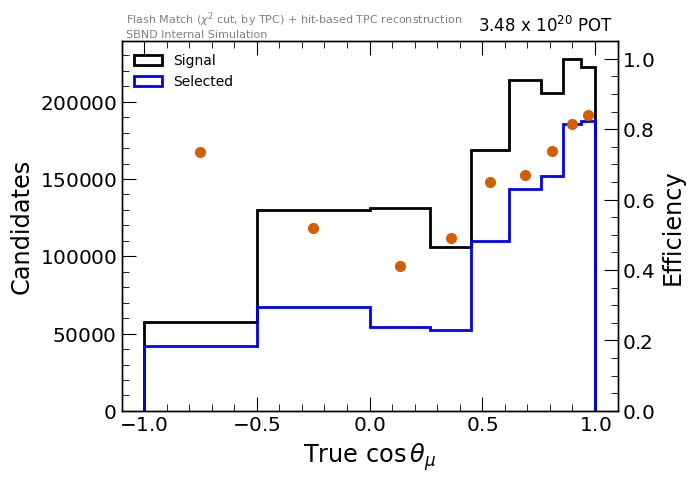

In [438]:
fig,ax = plt.subplots()
slc_costheta_sig_truth,_,_ = ax.hist(true_sig_costheta,bins=costheta_bins,weights=genweights_sig,label='Signal',histtype='step',color='black',alpha=1.)
slc_costheta_sel_truth,_,_ = ax.hist(true_sel_costheta,bins=costheta_bins,weights=genweights_sel,label='Selected',histtype='step',color='blue',alpha=1.)
slc_costheta_eff_truth = slc_costheta_sel_truth/slc_costheta_sig_truth
assert np.nanmax(slc_costheta_eff) <= 1.0, f'Efficiency is greater than 100%: {np.nanmax(slc_costheta_eff)}'
ax2 = ax.twinx()
ax2.scatter(costheta_centers,slc_costheta_eff_truth,label='Efficiency')
ax.set_xlabel(r'True $\cos\theta_{\mu}$')
ax.set_ylabel('Candidates')
ax2.set_ylim(0,1.05)
ax2.set_ylabel('Efficiency')

plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
plotters.add_label(ax,POT_LABEL,where='toprightoutside',color='black',alpha=1.,fontsize=12)
ax.legend()

plotters.save_plot('truth_costheta_sel_signal_eff',fig=fig,folder_name=f'{PLOT_DIR}/pandora')

### 3.2 Smearing matrix

In [439]:
from unfolding_inputs import get_smear_matrix

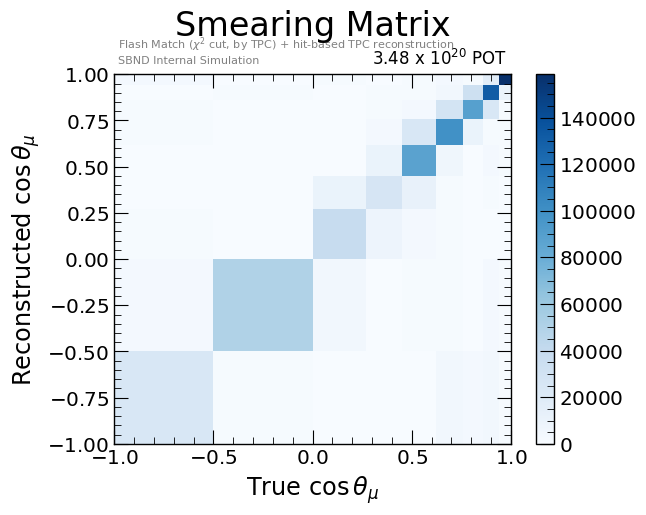

In [440]:
#True vs reco costheta
_slc_costheta_smearing = get_smear_matrix(true_sel_costheta,reco_sel_costheta,costheta_bins,weights=genweights_sel)
_eff = get_eff(_slc_costheta_smearing, slc_costheta_sig_truth)

fig,ax = plt.subplots()
im = ax.pcolormesh(costheta_bins,costheta_bins,_slc_costheta_smearing,cmap='Blues')
ax.set_xlabel(r'True $\cos\theta_{\mu}$')
ax.set_ylabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_title('Smearing Matrix')
fig.colorbar(im,ax=ax)
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.03+label_y_shift),fontsize=8,color='gray')
plotters.add_label(ax,POT_LABEL,where='toprightoutside',color='black',alpha=1.,fontsize=12)
plotters.save_plot('costheta_smearing_matrix',fig=fig,folder_name=f'{PLOT_DIR}/pandora')

### 3.3 Response matrix

In [441]:
from sbnd.stats import stats

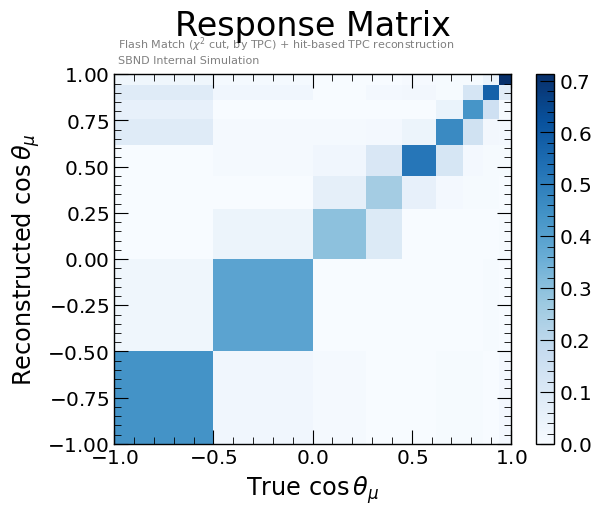

In [442]:
_slc_costheta_response = stats.convert_smearing_to_response(_slc_costheta_smearing,slc_costheta_eff_truth)

fig,ax = plt.subplots()
im = ax.pcolormesh(costheta_bins,costheta_bins,_slc_costheta_response,cmap='Blues')
fig.colorbar(im,ax=ax)
ax.set_xlabel(r'True $\cos\theta_{\mu}$')
ax.set_ylabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_title('Response Matrix')

plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.03+label_y_shift),fontsize=8,color='gray')
#plotters.add_label(ax,POT_LABEL,where='toprightoutside',color='black',alpha=1.,fontsize=12)
plotters.save_plot('costheta_response_matrix',fig=fig,folder_name=f'{PLOT_DIR}/pandora')

## 4. Flux

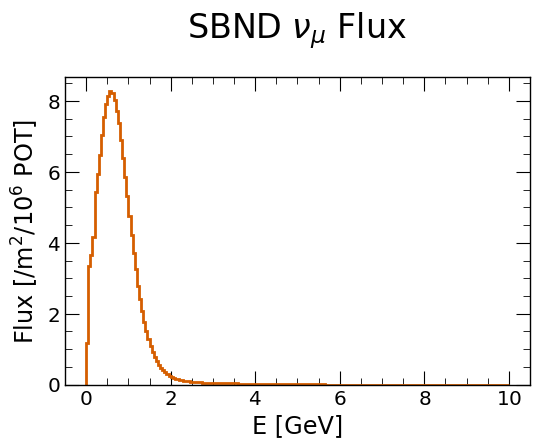

In [443]:
fig,ax = plt.subplots(figsize=(6,4))
ax.hist(bin_edges[:-1], bins=bin_edges, weights=flux_vals, histtype="step")
ax.set_xlabel("E [GeV]")
ax.set_ylabel("Flux [/m$^{2}$/10$^{6}$ POT]")
ax.set_title("SBND $\\nu_\\mu$ Flux")
fig.savefig(f'{PLOT_DIR}/flux.png')
plt.show()

## 5. Covariance Matrices

### 5.1 Stat

Data shape: (589,), Data range: -0.990 to 0.999
Found 100 universe weight columns
First few columns: [('truth', 'stat', 'univ_0', '', '', '', '', '', ''), ('truth', 'stat', 'univ_1', '', '', '', '', '', ''), ('truth', 'stat', 'univ_10', '', '', '', '', '', ''), ('truth', 'stat', 'univ_11', '', '', '', '', '', ''), ('truth', 'stat', 'univ_12', '', '', '', '', '', '')]
Histogram shape: (9, 100)
CV histogram shape: (9,)
CV histogram range: 37106.388 to 188905.249
CV histogram sum: 993439.211
Histogram range: 18553.194 to 242878.177
Histogram has NaN: False
Filtered weights range: 0.000 to 8.000
Filtered weights has NaN: False


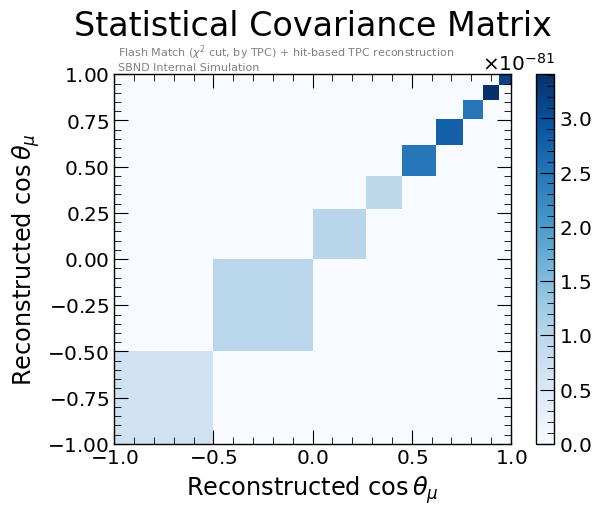

In [511]:
slc_stat_costheta_cov = slc_selected_signal.get_covariance('truth.stat','mu.pfp.trk.costheta',list(costheta_bins),stat=True,scale_cov=XSEC_UNIT,verbose=True)

fig,ax = plt.subplots()

im = ax.pcolormesh(costheta_bins,costheta_bins,slc_stat_costheta_cov,cmap='Blues')
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_title('Statistical Covariance Matrix')
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
fig.colorbar(im,ax=ax)
plotters.save_plot('stat_costheta',fig=fig,folder_name=f'{PLOT_DIR}/pandora/cov')

### 5.2 Flux

Data shape: (802,), Data range: -0.990 to 0.999
Found 1000 universe weight columns
First few columns: [('truth', 'Flux', 'univ_0', '', '', '', '', '', ''), ('truth', 'Flux', 'univ_1', '', '', '', '', '', ''), ('truth', 'Flux', 'univ_2', '', '', '', '', '', ''), ('truth', 'Flux', 'univ_3', '', '', '', '', '', ''), ('truth', 'Flux', 'univ_4', '', '', '', '', '', '')]
Histogram shape: (9, 1000)
CV histogram shape: (9,)
CV histogram range: 55708.875 to 201130.849
CV histogram sum: 1089155.926
Histogram range: 47172.014 to 285450.374
Histogram has NaN: False
Filtered weights range: 0.000 to 10.104
Filtered weights has NaN: False
Diff shape: (9, 1000)
Diff range: -53170.800 to 86305.481
Diff has NaN: False
Covariance matrix shape: (9, 9)
Covariance matrix has NaN: False
Covariance matrix range: 0.000000 to 0.000000


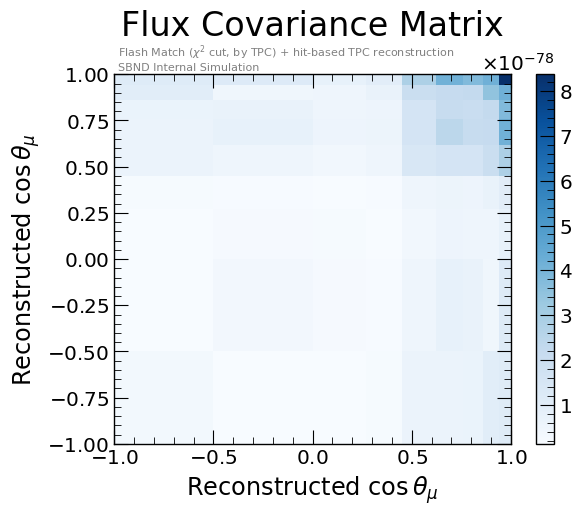

In [512]:
slc_flux_costheta_cov = slc.get_covariance('truth.Flux','mu.pfp.trk.costheta',list(costheta_bins),scale_cov=XSEC_UNIT,verbose=True)

fig,ax = plt.subplots()

im = ax.pcolormesh(costheta_bins,costheta_bins,slc_flux_costheta_cov,cmap='Blues')

ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_title('Flux Covariance Matrix')
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
fig.colorbar(im,ax=ax)
plotters.save_plot('flux_costheta',fig=fig,folder_name=f'{PLOT_DIR}/pandora/cov')

### 5.3 GENIE

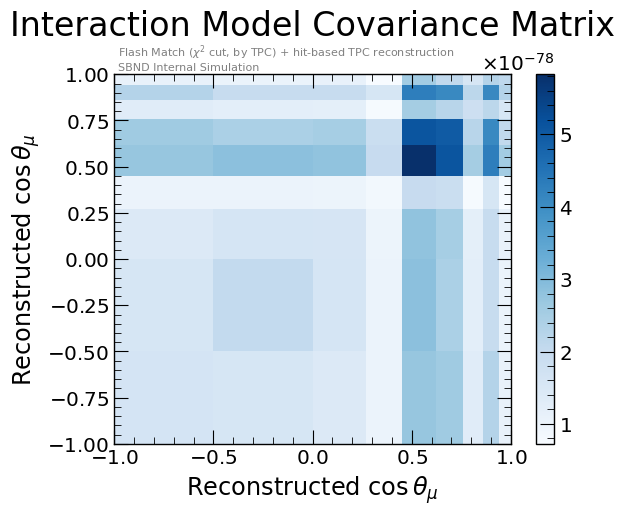

In [513]:
slc_genie_costheta_cov = slc.get_covariance('truth.GENIE','mu.pfp.trk.costheta',list(costheta_bins),scale_cov=XSEC_UNIT)

fig,ax = plt.subplots()
im = ax.pcolormesh(costheta_bins,costheta_bins,slc_genie_costheta_cov,cmap='Blues')
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_title('Interaction Model Covariance Matrix')
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
fig.colorbar(im,ax=ax)
plotters.save_plot('genie_costheta',fig=fig,folder_name=f'{PLOT_DIR}/pandora/cov')

### 5.X Total

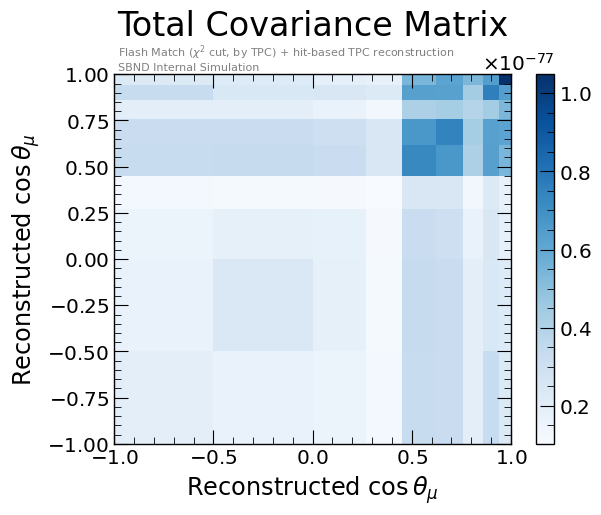

In [514]:
slc_total_costheta_cov = slc_stat_costheta_cov + slc_flux_costheta_cov + slc_genie_costheta_cov

fig,ax = plt.subplots()
im = ax.pcolormesh(costheta_bins,costheta_bins,slc_total_costheta_cov,cmap='Blues')
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_title('Total Covariance Matrix')
fig.colorbar(im,ax=ax)
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
plotters.save_plot('total_costheta',fig=fig,folder_name=f'{PLOT_DIR}/pandora/cov')

## 6. Unfolding

In [515]:
from analysis_village.unfolding import wienersvd
#WienerSVD(Response, Signal, Measure, Covariance, C_type, Norm_type)
C_type = 2
Norm_type = 0.5

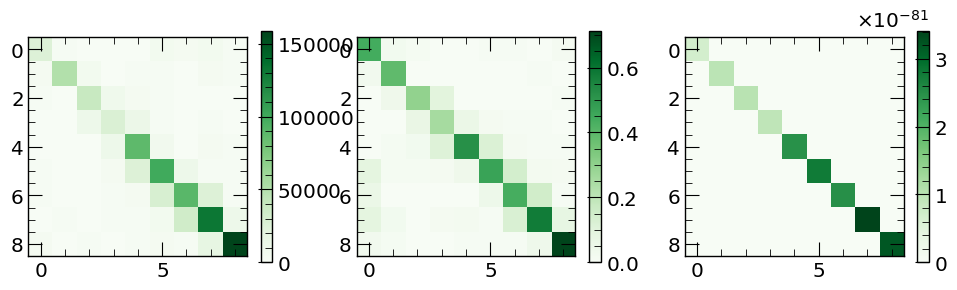

In [516]:
fig,ax = plt.subplots(figsize=(12,3),nrows=1,ncols=3)
im = ax[0].imshow(_slc_costheta_smearing)
fig.colorbar(im,ax=ax[0])
im = ax[1].imshow(_slc_costheta_response)
fig.colorbar(im,ax=ax[1])
im = ax[2].imshow(slc_stat_costheta_cov)
fig.colorbar(im,ax=ax[2])

### 6.1 Closure

In [592]:
scale_factor = XSEC_UNIT
#uniform_cov = np.eye(len(slc_costheta_sel)) * np.mean(np.diag(slc_stat_costheta_cov))

slc_costheta_unfold_dict = wienersvd.WienerSVD(
  _slc_costheta_response,
  slc_costheta_sig_truth*scale_factor, #signal
  slc_costheta_sel*scale_factor, #measured
  slc_stat_costheta_cov,#*scale_factor*scale_factor, 
  C_type, Norm_type)

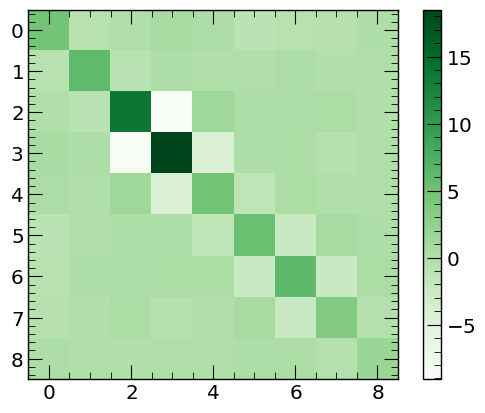

In [593]:
plt.imshow(slc_costheta_unfold_dict['UnfoldCov'])
plt.colorbar()

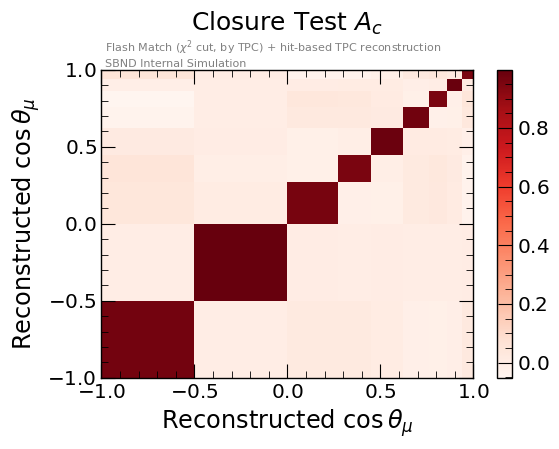

In [594]:
fig,ax = plt.subplots(figsize=(6,4))
im = ax.pcolormesh(costheta_bins,costheta_bins,slc_costheta_unfold_dict['AddSmear'],cmap='Reds')#,cmap='coolwarm',vmin=-1,vmax=1)
ax.set_title(r'Closure Test $A_c$',fontsize=18)
fig.colorbar(im,ax=ax)
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel(r'Reconstructed $\cos\theta_{\mu}$')
plotters.save_plot('costheta_unfold_smear',fig=fig,folder_name=f'{PLOT_DIR}/pandora/unfold')


In [598]:
slc_costheta_sig_smear = slc_costheta_unfold_dict['AddSmear'] @ slc_costheta_sig_truth * XSEC_UNIT * 1e38
slc_costheta_unfold = slc_costheta_unfold_dict['unfold']*1e38#*XSEC_UNIT*1e38

y = slc_costheta_sig_smear

ratio = y/slc_costheta_unfold

err = np.sqrt(np.diag(slc_stat_costheta_cov))*1e38
frac_err = err/slc_costheta_unfold

y_chi2,dof = stats.calc_chi2(slc_costheta_unfold,
  y,
  slc_stat_costheta_cov*(1e38*1e38))
y_chi2,dof

(1.8426064863154323e-15, 8)

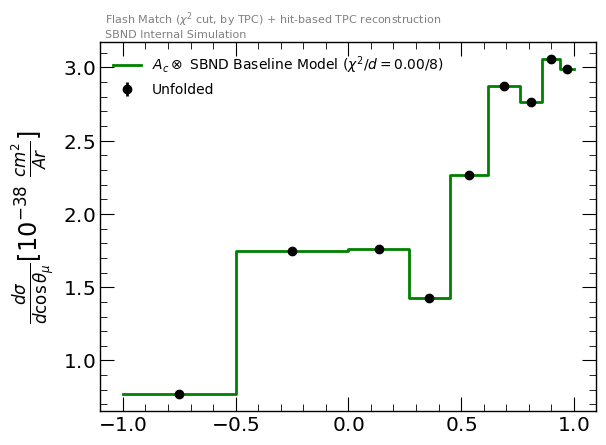

In [599]:
from sbnd.plotlibrary import makeplot
#fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,6),sharex=True,height_ratios=[4,1])
fig,ax1 = plt.subplots()
#ax1.scatter(costheta_centers,y,label='$A_c \\times$ True Signal')
#makeplot.plot_hist_edges(costheta_bins,slc_costheta_unfold,None,ax=ax1,color='blue',label='Unfolded')
makeplot.plot_hist_edges(costheta_bins,y,None,ax=ax1,color='green',label=f'$A_c \otimes$ SBND Baseline Model' + f' ($\chi^2/d = {y_chi2:.2f}/{dof}$)')
ax1.errorbar(costheta_centers,slc_costheta_unfold,yerr=err,color='black',label='Unfolded',fmt='o')
plotters.add_label(ax1,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
ax1.set_ylabel(r'$\frac{d\sigma}{d\cos\theta_{\mu}} [10^{-38} \ \frac{cm^2}{Ar}]$')
ax1.legend()
# ax2.scatter(costheta_centers,ratio)
# ax2.axhline(1,color='black',linestyle='--')
# ax2.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
# ax2.set_ylabel(r'Ratio')

### 6.2 Fake Data

In [600]:
slc_selected_signal_scaled = slc_selected_signal.copy()
slc_scaled = slc.copy()

background_mask = ~np.isin(slc.data.truth.event_type,[0,1])
background_cv = np.histogram(slc.data[background_mask].mu.pfp.trk.costheta,bins=costheta_bins,weights=slc.data[background_mask].genweight)[0]

In [601]:
mec_scale = 1.5

#Selected signal
mask = slc_selected_signal_scaled.data.truth.genie_mode == 10
col = slc_selected_signal_scaled.get_key('genweight')
slc_selected_signal_scaled.data.loc[mask,col] *= mec_scale
genweights_sel_scaled = slc_selected_signal_scaled.data.genweight.values

#Selected
mask = slc_scaled.data.truth.genie_mode == 10
col = slc_scaled.get_key('genweight')
slc_scaled.data.loc[mask,col] *= mec_scale
genweights_scaled = slc_scaled.data.genweight.values
slc_costheta_sel_scaled = np.histogram(slc_scaled.data.mu.pfp.trk.costheta,bins=costheta_bins,weights=genweights_scaled)[0]

In [602]:
slc_signal_scaled.data.genweight.value_counts(normalize=True)

genweight
1686.654009    0.859447
2529.981013    0.140553
Name: proportion, dtype: float64

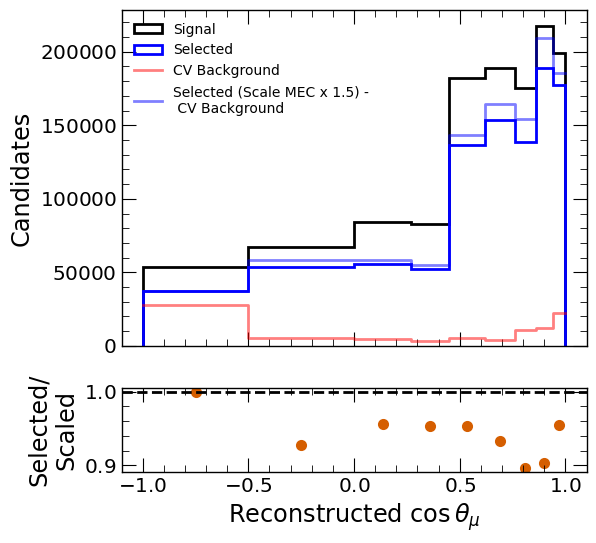

In [603]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,6),sharex=True,height_ratios=[4,1])

ax1.hist(reco_sig_costheta,bins=costheta_bins,weights=genweights_sig,label='Signal',histtype='step',color='black',alpha=1.)
_slc_costheta_sel,_,_ = ax1.hist(reco_sel_costheta,bins=costheta_bins,weights=genweights_sel,label='Selected',histtype='step',color='blue',alpha=1.)
makeplot.plot_hist_edges(costheta_bins,background_cv,None,ax=ax1,color='red',label='CV Background',alpha=0.5)
makeplot.plot_hist_edges(costheta_bins,slc_costheta_sel_scaled-background_cv,None,ax=ax1,color='blue',label=f'Selected (Scale MEC x {mec_scale}) -\n CV Background',alpha=0.5)
#slc_costheta_sel_scaled,_,_ = ax.hist(reco_costheta,bins=costheta_bins,weights=genweights_scaled,label=f'Selected (Scale MEC x {mec_scale})',histtype='step',color='blue',alpha=1.,ls='--')
ax1.set_ylabel('Candidates')
ax1.legend()
ax2.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax2.set_ylabel('Selected/\nScaled')
ax2.axhline(1,color='black',linestyle='--')
ax2.scatter(costheta_centers,_slc_costheta_sel/(slc_costheta_sel_scaled-background_cv))
plotters.add_label(ax,POT_LABEL,where='toprightoutside',color='black',alpha=1.,fontsize=12)
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
plotters.save_plot('costheta_sel_signal_mec_scale',fig=fig,folder_name=f'{PLOT_DIR}/pandora')

In [604]:
Measured = slc_costheta_sel_scaled-background_cv

In [605]:
scale_factor = XSEC_UNIT
#uniform_cov = np.eye(len(slc_costheta_sel)) * np.mean(np.diag(slc_stat_costheta_cov))

slc_costheta_unfold_fake_data_dict = wienersvd.WienerSVD(
  _slc_costheta_response,
  slc_costheta_sig_truth*scale_factor, #signal
  Measured*scale_factor, #measured
  slc_stat_costheta_cov+slc_genie_costheta_cov,#*scale_factor*scale_factor, 
  C_type, Norm_type)

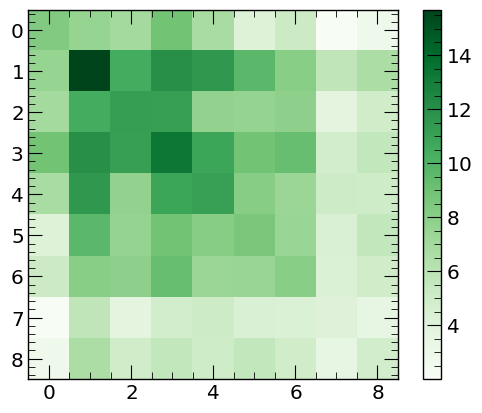

In [606]:
plt.imshow(slc_costheta_unfold_fake_data_dict['UnfoldCov'])
plt.colorbar()

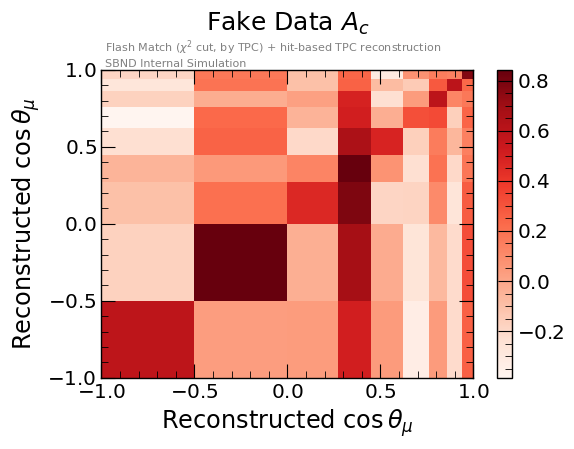

In [607]:
fig,ax = plt.subplots(figsize=(6,4))
im = ax.pcolormesh(costheta_bins,costheta_bins,slc_costheta_unfold_fake_data_dict['AddSmear'],cmap='Reds')#,cmap='coolwarm',vmin=-1,vmax=1)
ax.set_title(r'Fake Data $A_c$',fontsize=18)
fig.colorbar(im,ax=ax)
plotters.add_label(ax,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
ax.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')
ax.set_ylabel(r'Reconstructed $\cos\theta_{\mu}$')
plotters.save_plot('costheta_unfold_smear_fake_data',fig=fig,folder_name=f'{PLOT_DIR}/pandora/unfold')

In [608]:
slc_costheta_sig_smear_fake_data_scaled = slc_costheta_unfold_fake_data_dict['AddSmear'] @ slc_costheta_sig_truth * XSEC_UNIT * 1e38
slc_costheta_sig_smear_fake_data_nominal = slc_costheta_unfold_dict['AddSmear'] @ slc_costheta_sig_truth * XSEC_UNIT * 1e38
slc_costheta_unfold_fake_data = slc_costheta_unfold_fake_data_dict['unfold']*1e38#*XSEC_UNIT*1e38

y = slc_costheta_sig_smear_fake_data_scaled #Model with MEC scaling
y2 = slc_costheta_sig_smear_fake_data_nominal #Model with no scaling

ratio = y/slc_costheta_unfold_fake_data
ratio2 = y2/slc_costheta_unfold_fake_data

err = np.sqrt(np.diag(slc_stat_costheta_cov+slc_genie_costheta_cov))*1e38
frac_err = err/slc_costheta_unfold_fake_data
#unfolded_err = np.sqrt(np.diag(slc_costheta_unfold_fake_data_dict['UnfoldCov']))#/slc_costheta_unfold_fake_data

#Chi2 
y_chi2,dof = stats.calc_chi2(slc_costheta_unfold_fake_data,
  y,
  (slc_stat_costheta_cov+slc_genie_costheta_cov)*(1e38*1e38))
y2_chi2,dof = stats.calc_chi2(slc_costheta_unfold_fake_data,
  y2,
  (slc_stat_costheta_cov+slc_genie_costheta_cov)*(1e38*1e38))

y_chi2,y2_chi2

(64.26447959521347, 60.591354682732586)

In [609]:
slc_costheta_unfold_fake_data,y2

(array([0.64281538, 1.60852397, 1.59808288, 1.48539425, 2.27968377,
        2.95632308, 2.99534262, 3.3945794 , 3.24499293]),
 array([0.77128299, 1.74405264, 1.76322123, 1.42819578, 2.26338703,
        2.87698698, 2.76569915, 3.05669646, 2.98856508]))

In [610]:
r'$A_c \otimes$ Fake Data'+f' (Mec Scale x {mec_scale})'

'$A_c \\otimes$ Fake Data (Mec Scale x 1.5)'

Text(0.5, 0, 'Reconstructed $\\cos\\theta_{\\mu}$')

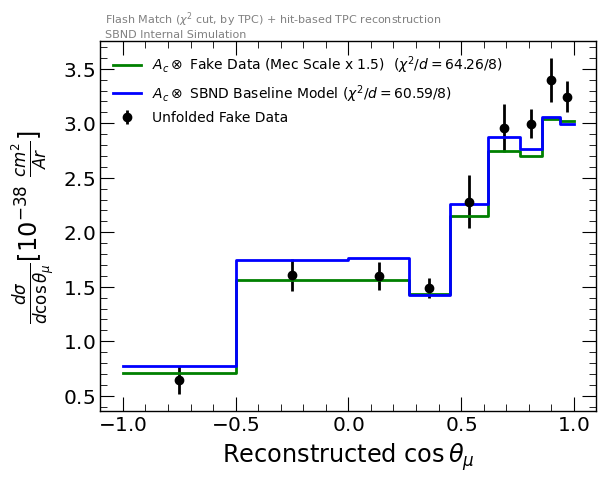

In [611]:
from sbnd.plotlibrary import makeplot


#fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,6),sharex=True,height_ratios=[4,1])
fig,ax1 = plt.subplots()
#ax1.scatter(costheta_centers,y,label='$A_c \\times$ True Signal')
#makeplot.plot_hist_edges(costheta_bins,slc_costheta_unfold_fake_data,None,ax=ax1,color='blue',label='Unfolded')
ax1.errorbar(costheta_centers,slc_costheta_unfold_fake_data,yerr=err,color='black',label='Unfolded Fake Data',fmt='o')
makeplot.plot_hist_edges(costheta_bins,y,None,ax=ax1,color='green',label='$A_c \otimes$ Fake Data'+f' (Mec Scale x {mec_scale}) ' + f' ($\chi^2/d = {y_chi2:.2f}/{dof}$)')
makeplot.plot_hist_edges(costheta_bins,y2,None,ax=ax1,color='blue',label='$A_c \otimes$ SBND Baseline Model' + f' ($\chi^2/d = {y2_chi2:.2f}/{dof}$)')
plotters.add_label(ax1,PANDORA_QUALIFIER_INTERNAL_LABEL,where=(0.01,1.01+label_y_shift),fontsize=8,color='gray')
ax1.set_ylabel(r'$\frac{d\sigma}{d\cos\theta_{\mu}} [10^{-38} \ \frac{cm^2}{Ar}]$')
ax1.legend()
ax1.set_xlabel(r'Reconstructed $\cos\theta_{\mu}$')

# ax2.scatter(costheta_centers,ratio)
# ax2.axhline(1,color='black',linestyle='--')
# ax2.set_ylabel(r'Ratio')

## Testing

In [812]:
from analysis_village.unfolding.wienersvd import WienerSVD

print("=== Test 1: Perfect Case ===")
n_bins = 5
identity_response = np.eye(n_bins)
identity_response[1,0] = 0.1
test_signal = np.array([100.0, 100.0, 100.0, 100.0, 100.0])
test_measured = test_signal.copy()  # Same as signal
test_measured[1] = 1000.0
test_cov = np.diag(test_signal)*100  # Identity covariance

result1 = WienerSVD(identity_response, test_signal, test_measured, test_cov, 0, 0.0)
print(f"Unfolded result: {result1['unfold']}")
print(f"Should equal signal: {np.allclose(result1['unfold'], test_signal)}")
print(f"AddSmear should be identity: {np.allclose(result1['AddSmear'], np.eye(n_bins))}")
print("AddSmear matrix:")
print(result1['AddSmear'])
print(f"AddSmear diagonal: {np.diag(result1['AddSmear'])}")
print(f"AddSmear column sums: {np.sum(result1['AddSmear'], axis=0)}")

=== Test 1: Perfect Case ===
-Response: [[1.  0.  0.  0.  0. ]
 [0.1 1.  0.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]]
-Signal: [100. 100. 100. 100. 100.]
-Measure: [ 100. 1000.  100.  100.  100.]
-Covariance: [[10000.     0.     0.     0.     0.]
 [    0. 10000.     0.     0.     0.]
 [    0.     0. 10000.     0.     0.]
 [    0.     0.     0. 10000.     0.]
 [    0.     0.     0.     0. 10000.]]
-C_type: 0
-Norm_type: 0.0
-U_cov: [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
-s_cov: [10000. 10000. 10000. 10000. 10000.]
-Q0: [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
-Q: [[0.01 0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.01]]
-M_trans: [ 1. 10.  1.  1.  1.]
-R: [[0.01  0.    0.    0.    0.   ]
 [0.001 0.01  0.    0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0

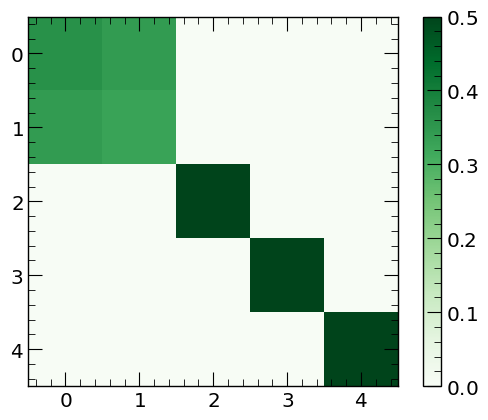

In [813]:
plt.imshow(result1['AddSmear'])
plt.colorbar()

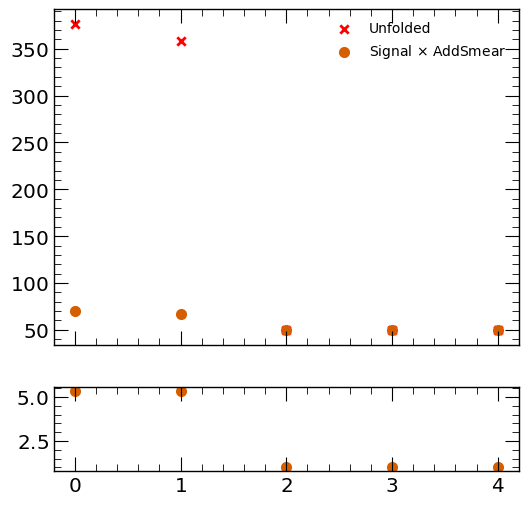

In [814]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,6),sharex=True,height_ratios=[4,1])
ax1.scatter(np.arange(n_bins),result1['unfold'],marker='x',color='red',label='Unfolded')
ax1.scatter(np.arange(n_bins),test_signal@result1['AddSmear'],label=r'Signal $\times$ AddSmear')
ax2.scatter(np.arange(n_bins),result1['unfold']/(test_signal@result1['AddSmear']))
ax1.legend()


In [808]:
_inter = inter.copy()

In [282]:
flux_keys = list(set([k[1] for k in _inter.data.keys() if 'Flux' in k[1]]))
with open('flux_keys.txt','w') as f:
  f.write(str(flux_keys))
flux_keys


['pionqexsec_Flux',
 'kplus_Flux',
 'pioninexsec_Flux',
 'nucleontotxsec_Flux',
 'nucleoninexsec_Flux',
 'horncurrent_Flux',
 'piplus_Flux',
 'piontotxsec_Flux',
 'kminus_Flux',
 'expskin_Flux',
 'nucleonqexsec_Flux',
 'Flux',
 'piminus_Flux',
 'kzero_Flux']

In [271]:
genie_keys = list(set([k[1] for k in slc.data.keys() if 'GENIE' in k[1]]))
genie_keys

['GENIEReWeight_SBN_v1_multisigma_NormNCMEC',
 'GENIEReWeight_SBN_v1_multisigma_ThetaDelta2NRad',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvnCC2pi',
 'GENIEReWeight_SBN_v1_multisigma_RDecBR1eta',
 'GENIE',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpCC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvnCC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvpNC2pi',
 'GENIEReWeight_SBN_v1_multisigma_NormNCCOH',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnNC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NormCCCOH',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvpCC1pi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvpNC1pi',
 'GENIEReWeight_SBN_v1_multisigma_Theta_Delta2Npi',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvpCC2pi',
 'GENIEReWeight_SBN_v1_multisigma_RDecBR1gamma',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpCC2pi',
 'GENIEReWeight_SBN_v1_multisigma_VecFFCCQEshape',
 'GENIEReWeight_SBN_v1_multisigma_DecayAngMEC',
 'GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnNC2pi',
 'GENIEReWeight_SBN_v

In [83]:
_inter.add_stat_unc()

Generating event seeds: 100%|██████████| 309285/309285 [00:02<00:00, 110934.58it/s]


Successfully generated 309285 unique seeds


Generating universes: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


In [86]:
_inter.data.truth.stat.univ_0.value_counts(normalize=True)

univ_0
1.0    0.367936
0.0    0.367386
2.0    0.184655
3.0    0.061238
4.0    0.015167
5.0    0.002971
6.0    0.000566
7.0    0.000061
8.0    0.000019
Name: proportion, dtype: float64

In [160]:
fname = f'{os.path.join(DATA_DIR,"small/mc_small_syst_postprocess_cut.df")}'
#df = pd.read_hdf(fname,key='evt_0')

In [38]:
list(df.keys())

[('id', '', '', '', '', ''),
 ('is_cathode_crosser_x', '', '', '', '', ''),
 ('is_contained_x', '', '', '', '', ''),
 ('is_fiducial_x', '', '', '', '', ''),
 ('is_flash_matched', '', '', '', '', ''),
 ('is_truth', '', '', '', '', ''),
 ('num_particles_x', '', '', '', '', ''),
 ('num_primary_particles_x', '', '', '', '', ''),
 ('vertex', 'x', '', '', '', ''),
 ('vertex', 'y', '', '', '', ''),
 ('vertex', 'z', '', '', '', ''),
 ('flash_hypo_pe', '', '', '', '', ''),
 ('flash_total_pe', '', '', '', '', ''),
 ('match_overlaps', '', '', '', '', ''),
 ('current_type', '', '', '', '', ''),
 ('energy_init', '', '', '', '', ''),
 ('energy_transfer', '', '', '', '', ''),
 ('num_particles_y', '', '', '', '', ''),
 ('num_primary_particles_y', '', '', '', '', ''),
 ('inelasticity', '', '', '', '', ''),
 ('interaction_mode', '', '', '', '', ''),
 ('interaction_type', '', '', '', '', ''),
 ('is_cathode_crosser_y', '', '', '', '', ''),
 ('is_contained_y', '', '', '', '', ''),
 ('is_fiducial_y', '', ''

In [161]:
with h5py.File(fname, 'r') as f:
    keys = list(f.keys())  # Convert the KeysViewWithLock object to a list for easier viewing
    print(keys)

['mcnu', 'pandora', 'pandora_signal', 'spine', 'spine_signal']
